### VAR Lag Length Selection

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [129]:
# read factor
code = input()
data = pd.read_csv(r'.\input\factor\ten_factor_vw_{}_week_5.csv'.format(code), index_col = 0)
data.index = pd.to_datetime(data.index)
data["market"] -= data["rf"]
data = data.iloc[:, :11]

cn800


In [3]:
# store aic values
aic = {}

# store forecast values
fore = {}

for t in range(len(data.index)-260):
    X = data.iloc[t:260+t,]
    X.index = pd.Series(range(len(X.index)))
    aic_ls = []
    var_model = VAR(X)
    for p in range(1,10):
        results = var_model.fit(p)
        aic_ls.append(results.aic)
        if p == 1:
            f_mean = results.forecast(X.values[-1:], 4)[3]
            fore[260+t] = f_mean
    aic[260+t] = aic_ls

### Prediction Stability
us: forecast values are much volatile than rolling means, but performance

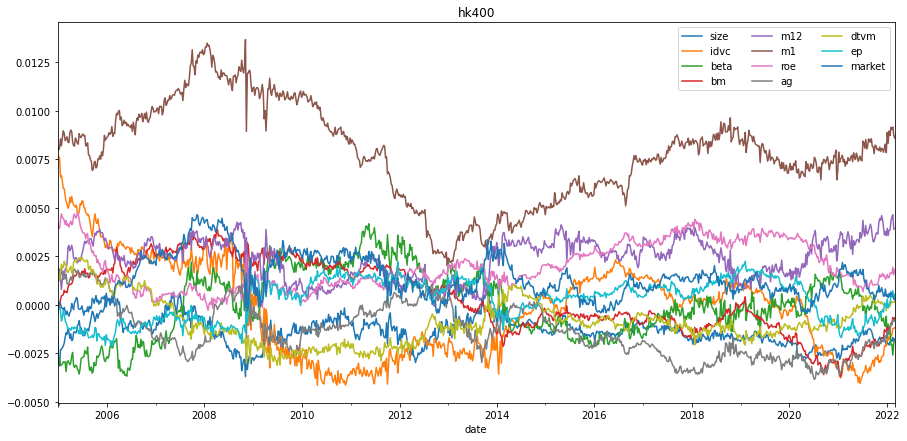

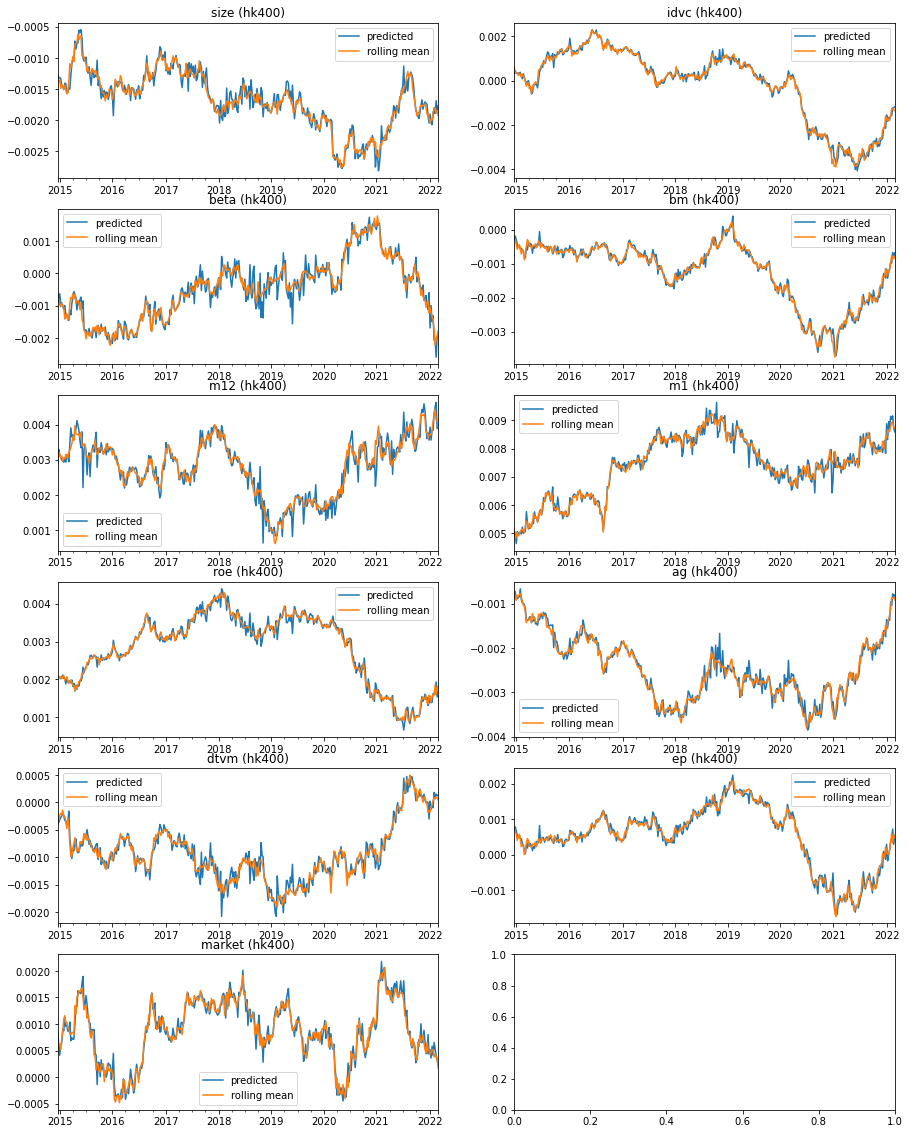

In [4]:
fore_df = pd.DataFrame.from_dict(fore, orient='index')
fore_df.columns = data.columns
fore_df.index = data.index[260:]
fore_df.plot(figsize=(15,7),title=code)
plt.legend(fore_df.columns, ncol = 3)

fig, axes = plt.subplots(figsize=(15, 20), nrows=6, ncols=2)
for i, col in enumerate(data.columns):
    coli = i%2
    rowi = i//2
    rolling = data[col].rolling(window=260).mean()
    tmp = pd.DataFrame(fore_df[col]).join(rolling, rsuffix="_")
#     tmp = tmp.join(data[col][260:].shift(-4),rsuffix="__")
    tmp.columns = ["predicted", "rolling mean"]
    tmp[520:].plot( title="{} ({})".format(col, code), ax = axes[rowi, coli])
    axes[rowi, coli].set_xlabel("")

### Model Selection
- us: different orders only have obvious aic different during 2016 to 2020 where lag 1 gives the minimum
- cn: only have obvious aic difference during 2010 to 2012 where lag 1 gives slightly better aix
- hk: different orders only have obvious aic different during 2014 to 2020 where lag 1 gives the minimum

<AxesSubplot:xlabel='date'>

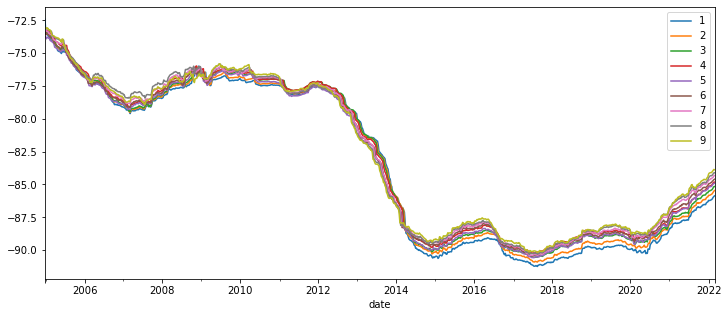

In [5]:
aic_df = pd.DataFrame.from_dict(aic, orient='index')
aic_df.columns = pd.Series(range(1,10))
aic_df.index = data.index[260:]
aic_df.plot(figsize=(12,5))

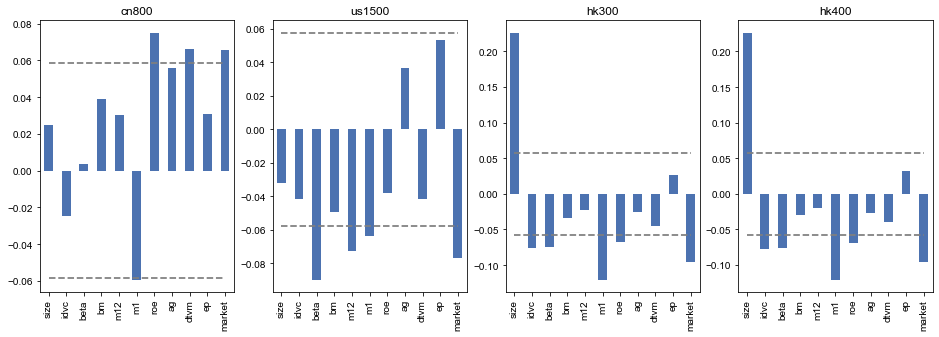

In [6]:
fig, axes = plt.subplots(figsize = (16,5), ncols = 4)
plt.style.use('seaborn')
for i, code in enumerate(['cn800', 'us1500', 'hk300', 'hk400']):
    data = pd.read_csv(r'.\input\factor\ten_factor_vw_{}_week_5.csv'.format(code), index_col = 0)
    data.index = pd.to_datetime(data.index)
    data["market"] -= data["rf"]
    data = data.iloc[:, :11]
    ci = 1.96/np.sqrt(len(data.index))
    df = pd.Series({col: data[col].autocorr(1) for col in data.columns})
    df.plot.bar(ax = axes[i], title=code)
    pd.Series({col: ci for col in data.columns}).plot(ax = axes[i],style='--',color='tab:gray')
    pd.Series({col: -ci for col in data.columns}).plot(ax = axes[i],style='--',color='tab:gray', rot=90, grid=False)

### Correlations

In [7]:
for i, code in enumerate(['cn800', 'us1500', 'hk300', 'hk400']):
    data = pd.read_csv(r'.\input\factor\ten_factor_vw_{}_week_5.csv'.format(code), index_col = 0)
    data.index = pd.to_datetime(data.index)
    data["market"] -= data["rf"]
    data = data.iloc[:, :11]
    display(data.corr().style.background_gradient().set_caption(code))

,size,idvc,beta,bm,m12,m1,roe,ag,dtvm,ep,market
size,1.000000,-0.570702,0.473675,-0.443782,-0.038253,0.283720,-0.788791,-0.287009,0.799741,-0.768604,-0.024850
idvc,-0.570702,1.000000,-0.685612,0.720494,-0.454165,-0.006311,0.360556,-0.157155,-0.205124,0.721581,0.013534
beta,0.473675,-0.685612,1.000000,-0.371552,0.153995,0.187685,-0.388548,0.061970,0.094198,-0.579699,-0.052186
bm,-0.443782,0.720494,-0.371552,1.000000,-0.550283,0.018362,0.111219,-0.394160,-0.258181,0.698997,0.000764
m12,-0.038253,-0.454165,0.153995,-0.550283,1.000000,-0.101691,0.232399,0.374303,-0.181379,-0.198134,-0.004932
m1,0.283720,-0.006311,0.187685,0.018362,-0.101691,1.000000,-0.195700,-0.014196,0.260780,-0.119089,-0.090295
roe,-0.788791,0.360556,-0.388548,0.111219,0.232399,-0.195700,1.000000,0.497168,-0.670767,0.684060,0.026781
ag,-0.287009,-0.157155,0.061970,-0.394160,0.374303,-0.014196,0.497168,1.000000,-0.366563,0.031571,0.002619
dtvm,0.799741,-0.205124,0.094198,-0.258181,-0.181379,0.260780,-0.670767,-0.366563,1.000000,-0.531526,-0.029454
ep,-0.768604,0.721581,-0.579699,0.698997,-0.198134,-0.119089,0.684060,0.031571,-0.531526,1.000000,0.009922


,size,idvc,beta,bm,m12,m1,roe,ag,dtvm,ep,market
size,1.000000,-0.418764,0.356343,0.313910,-0.122486,-0.112652,-0.426023,0.047994,0.734034,-0.164846,0.025990
idvc,-0.418764,1.000000,-0.856972,-0.006798,0.055038,0.170438,0.763979,0.442652,0.123576,0.700139,0.029646
beta,0.356343,-0.856972,1.000000,0.077855,-0.123011,-0.261889,-0.691801,-0.396593,-0.157970,-0.559073,-0.030165
bm,0.313910,-0.006798,0.077855,1.000000,-0.693235,-0.302456,-0.312590,0.523951,0.449192,0.470699,0.005760
m12,-0.122486,0.055038,-0.123011,-0.693235,1.000000,0.297867,0.284095,-0.353025,-0.164962,-0.359029,0.011760
m1,-0.112652,0.170438,-0.261889,-0.302456,0.297867,1.000000,0.226576,0.030104,0.014689,-0.057553,0.033578
roe,-0.426023,0.763979,-0.691801,-0.312590,0.284095,0.226576,1.000000,0.149094,-0.029758,0.577565,0.017122
ag,0.047994,0.442652,-0.396593,0.523951,-0.353025,0.030104,0.149094,1.000000,0.356291,0.504906,0.050968
dtvm,0.734034,0.123576,-0.157970,0.449192,-0.164962,0.014689,-0.029758,0.356291,1.000000,0.321862,0.051830
ep,-0.164846,0.700139,-0.559073,0.470699,-0.359029,-0.057553,0.577565,0.504906,0.321862,1.000000,-0.009537


,size,idvc,beta,bm,m12,m1,roe,ag,dtvm,ep,market
size,1.000000,-0.237221,-0.148227,0.206102,-0.046217,-0.094837,-0.016248,0.072207,0.356455,-0.153544,0.019654
idvc,-0.237221,1.000000,-0.181121,0.015227,-0.098023,0.168552,0.076696,0.255383,0.060889,0.115203,-0.028983
beta,-0.148227,-0.181121,1.000000,0.040329,0.057397,-0.092248,-0.068630,-0.370779,-0.469034,0.068877,-0.029127
bm,0.206102,0.015227,0.040329,1.000000,-0.159290,-0.049692,0.062696,0.102701,0.030715,0.366238,0.015200
m12,-0.046217,-0.098023,0.057397,-0.159290,1.000000,0.042601,0.060099,-0.131335,-0.073743,-0.028042,-0.007097
m1,-0.094837,0.168552,-0.092248,-0.049692,0.042601,1.000000,0.018945,0.028573,0.020653,-0.071118,0.073092
roe,-0.016248,0.076696,-0.068630,0.062696,0.060099,0.018945,1.000000,0.044406,0.101110,0.341189,0.013264
ag,0.072207,0.255383,-0.370779,0.102701,-0.131335,0.028573,0.044406,1.000000,0.386339,-0.108089,-0.004875
dtvm,0.356455,0.060889,-0.469034,0.030715,-0.073743,0.020653,0.101110,0.386339,1.000000,-0.296364,-0.006127
ep,-0.153544,0.115203,0.068877,0.366238,-0.028042,-0.071118,0.341189,-0.108089,-0.296364,1.000000,0.039195


,size,idvc,beta,bm,m12,m1,roe,ag,dtvm,ep,market
size,1.000000,-0.227653,-0.161931,0.211513,-0.052881,-0.090979,-0.015954,0.082085,0.365176,-0.149757,0.018961
idvc,-0.227653,1.000000,-0.174800,0.005156,-0.094709,0.170362,0.078077,0.258091,0.070698,0.107114,-0.029543
beta,-0.161931,-0.174800,1.000000,0.046644,0.050537,-0.097802,-0.071746,-0.379145,-0.488597,0.069770,-0.025024
bm,0.211513,0.005156,0.046644,1.000000,-0.154083,-0.044831,0.063431,0.105820,0.054384,0.359846,0.013750
m12,-0.052881,-0.094709,0.050537,-0.154083,1.000000,0.037176,0.061959,-0.134829,-0.084527,-0.019596,-0.006653
m1,-0.090979,0.170362,-0.097802,-0.044831,0.037176,1.000000,0.019099,0.034187,0.016209,-0.064909,0.073631
roe,-0.015954,0.078077,-0.071746,0.063431,0.061959,0.019099,1.000000,0.060237,0.103205,0.340474,0.012871
ag,0.082085,0.258091,-0.379145,0.105820,-0.134829,0.034187,0.060237,1.000000,0.405451,-0.098261,-0.001996
dtvm,0.365176,0.070698,-0.488597,0.054384,-0.084527,0.016209,0.103205,0.405451,1.000000,-0.281471,-0.004252
ep,-0.149757,0.107114,0.069770,0.359846,-0.019596,-0.064909,0.340474,-0.098261,-0.281471,1.000000,0.036353


### Model validations

In [103]:
exog_group = {'hk400': ['cn800', 'us1500'], 'cn800': ['hk400','us1500'], 'us1500': ['cn800', 'hk400']}
exog_group2 = ['.dMIEF00000G', '.dMIEA00000G', '.DXY', 'US10YT=RR']

# get endogenous data
code = "us1500"
datar = pd.read_csv(r'.\input\factor\ten_factor_vw_{}_week_5.csv'.format(code), index_col = 0)
datar.index = pd.to_datetime(datar.index)
datar["market"] -= datar["rf"]
endog = datar.iloc[:, :11]

# get exogenous data
exog = pd.DataFrame()
for c in exog_group[code]:
    data = pd.read_csv(r'.\input\factor\ten_factor_vw_{}_week_5.csv'.format(c), index_col = 0)
    data.index = pd.to_datetime(data.index)
    one_exog = data['market'] - data['rf']
    one_exog.name = '%s_market' %c[:2]
    if exog.empty:
        exog[one_exog.name] = one_exog
        exog.index = one_exog.index
    else:
        exog = exog.join(one_exog, how='outer')

exog_external = pd.read_csv(r'.\input\factor\exogs_weekly.csv', index_col = 0)
exog_external.index = pd.to_datetime(exog_external.index)
exog_external = exog_external[exog_group2]
exog_external.columns = ['em', 'dm', 'usd', 'tbill']
exog = exog.join(exog_external, how = 'inner')


# align dates of exogenous and endogenous
if not exog.empty:
    inter = set(endog.index).intersection(set(exog.index))
#     endog = endog[endog.index.isin(inter)]
#     exog = exog[exog.index.isin(inter)] ## left join
    exog = exog.join(endog, how='right').iloc[:,:len(exog.columns)]
    exog = exog.fillna(0)

# align matrix for testing
if exog.empty:
    df_test = exog
else:
    df_test = pd.concat([exog, endog], axis =1)
#     df_test = df_test.dropna(how='any')

In [104]:
# Granger's Causality Test (Prediction power of one series to another) - the smaller the p-value, the stronger the relationships
p = len(df_test.columns)
df_test = df_test.dropna(how='any')
from statsmodels.tsa.stattools import grangercausalitytests
df = pd.DataFrame(np.zeros((p, p)), columns = df_test.columns, index = df_test.columns)
for c in df.columns:
    for r in df.index:
        res = grangercausalitytests(df_test[[r, c]], maxlag=12, verbose=False)
        p_values = [round(res[i+1][0]['ssr_chi2test'][1], 4) for i in range(12)]
        df.loc[r,c] = np.min(p_values)
df.columns = [var +"_x" for var in df.columns]
df.index = [var +"_y" for var in df.index]
display(df.style.background_gradient())

if (df.min()>=0.05).any():
    print(df_test.columns[df.min()>=0.05])
else:
    print("Results: all passed")

,cn_market_x,hk_market_x,em_x,dm_x,usd_x,tbill_x,size_x,idvc_x,beta_x,bm_x,m12_x,m1_x,roe_x,ag_x,dtvm_x,ep_x,market_x
cn_market_y,1.000000,0.009200,0.001000,0.000000,0.048000,0.199200,0.262600,0.066900,0.010700,0.041700,0.137800,0.156600,0.006100,0.603500,0.621300,0.121600,0.000000
hk_market_y,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002100,0.001200,0.002900,0.000000,0.000000,0.002400,0.000000,0.000000
em_y,0.079400,0.000100,1.000000,0.000000,0.398900,0.199100,0.000000,0.000000,0.000000,0.000000,0.001000,0.000000,0.000000,0.000000,0.099800,0.000000,0.000000
dm_y,0.013200,0.000000,0.001100,1.000000,0.283900,0.045300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010200,0.003300,0.000000,0.003900
usd_y,0.169500,0.334200,0.008400,0.041800,1.000000,0.078300,0.001000,0.000000,0.001700,0.009300,0.045100,0.000900,0.002300,0.687800,0.014100,0.133400,0.050800
tbill_y,0.020500,0.015700,0.002200,0.000500,0.094000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.089800,0.000000,0.552600,0.050800,0.258400,0.001700
size_y,0.146600,0.035800,0.006100,0.004800,0.154700,0.162900,1.000000,0.000200,0.005600,0.000500,0.000200,0.000000,0.000400,0.129600,0.003800,0.010500,0.018300
idvc_y,0.001100,0.003200,0.001200,0.000100,0.036900,0.006300,0.000300,1.000000,0.304300,0.004800,0.110000,0.006600,0.000000,0.024900,0.000100,0.002700,0.000000
beta_y,0.015100,0.001900,0.001400,0.000100,0.127800,0.008700,0.007300,0.002900,1.000000,0.014300,0.194900,0.010400,0.000000,0.047100,0.009200,0.011900,0.000000
bm_y,0.090600,0.000100,0.000000,0.000100,0.203200,0.069700,0.161600,0.129500,0.403400,1.000000,0.165400,0.000100,0.016200,0.001700,0.296600,0.060100,0.000800


Results: all passed


In [105]:
# stationary test - ADF
from statsmodels.tsa.stattools import adfuller
p_values = [round(adfuller(df_test[col])[1],5) for col in df_test.columns]
p_values

[1e-05,
 0.0,
 0.0,
 0.0,
 0.0,
 0.13639,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [135]:
# cointegration
from statsmodels.tsa.vector_ar.vecm import coint_johansen
out = coint_johansen(df_test[['acwi','em','dm']], -1, 5)
out.cvt

array([[21.7781, 24.2761, 29.5147],
       [10.4741, 12.3212, 16.364 ],
       [ 2.9762,  4.1296,  6.9406]])

### VARX model test
- `VAR` model: using the OLS estimator to estimate params (formula computation), methodologies please refer to textbook p.69
- `VARMA` model: using MLE estimator, calling scipy.optimize to maximize MLE. In practice it runs quite slow (2-3 min each model) and do not converge every time.

#### References:
- [VAR](https://www.statsmodels.org/dev/generated/statsmodels.tsa.vector_ar.var_model.VAR.html)
- [VARResults](https://www.statsmodels.org/dev/generated/statsmodels.tsa.vector_ar.var_model.VARResults.html)


#### Findings:
- VARX(1) model is now implemented with VAR class in `statsmodels`. 
- as compared to rolling mean and VAR(1), VARX's prediction is much more volatile, probably due to the fact that `exog_future` now used the last market return for the return in the next 4 weeks, so the prediction is much reliant on the latest market value.
- if we use average market return in the rolling window as the market return for the next 4 weeks, the prediction is very close to rolling mean. Since the coef of other factors are small and intercept + beta $\times$ exog is close to average level

#### Findings: (new external variables)
- for us market, no external variable has shown significant accross the whole horizon. But most of them proved to be significant over a short period of time. In particular, em and dm showed good significance for longer period of time. 10-y tbill started to get significant in the recent two years.
- how about **non-stationarity** of T-bill series? how about **cointegration effect** between em, dm and acwi?
- for cn, `dm` and `em` are not very significant after 2014

In [106]:
# check for significance of the two additional variables
import numpy.linalg as linalg

m = len(endog.index)
t_values = {}
for raw_name in exog.columns:
    t_values[raw_name] = {}
    
fore = {}
fore2 = {}
for i in range(1, m-260):
    # get window data
    exogf = exog.iloc[(i-1):i+259,:]
    endogf = endog.iloc[i:i+260, :]
    endogf.index = range(260)
    exogf.index = range(260)
    
    # fit model
    mod = sm.tsa.VAR(endogf, exog=exogf)
    res = mod.fit(1)
    
    # store t_values
    for variable in t_values.keys():
        t_values[variable][i+260] = res.tvalues.loc[variable,:].values
        
    # predict
    exog_t = exog.iloc[i+260,:].values
    exog_t1 = np.mean(exog.iloc[i+151:i+261])
    exog_future = np.reshape(np.concatenate([exog_t, exog_t1, exog_t1, exog_t1]), (4, exog.shape[1])) # assume a stable market in the next 4 weeks
    fore[i+260] = res.forecast(endogf.values[-1:], exog_future=exog_future, steps = 4)[3]
    
    # compute covar
    n = len(endog.columns)
    k = len(exog.columns)
    A = res.params.iloc[1+k:, :].T
    B = res.params.iloc[1:1+k, :].T
    term1 = linalg.inv(np.diag(np.ones(n * n)) - np.kron(A, A))
    term2 = np.dot(np.kron(B, B), np.reshape(exog.cov().values, k*k)) + np.reshape(res.sigma_u.values, newshape=121, order='F')
    f_sigma_vec = np.dot(term1, term2)
    f_sigma = np.reshape(f_sigma_vec, (n, n))
    
    if (abs(linalg.eigvals(A))>1).any():
        print("not stable at time {}".format(i))
    
    if (linalg.eigvals(f_sigma)<0).any():
        print("not positive semi-definite at time {}".format(i))
        
    if not res.is_stable():
        print("not stable based on params")

    # simple var model
    mod2 = sm.tsa.VAR(endogf)
    res2 = mod2.fit(1)
    fore2[i+260] = res2.forecast(endogf.values[-1:], steps = 4)[3]
    
    # print the most recent result
    if i == m -260-1:
        print(res.summary())
        print("")

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 07, Jun, 2022
Time:                     11:51:55
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                   -88.2186
Nobs:                     259.000    HQIC:                  -89.8445
Log likelihood:           7931.88    FPE:                3.21596e-40
AIC:                     -90.9377    Det(Omega_mle):     1.53579e-40
--------------------------------------------------------------------
Results for equation size
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.003076         0.003159            0.974           0.330
cn_market        -0.031202         0.061831           -0.505           0.614
hk_market         0.022240         0.045171            0.492           0.622


In [81]:
variables = list(res.params.index)
for col in endog.columns: 
    print("=== significant variables for <{}>".format(col))
    print(res.tvalues.loc[abs(res.tvalues[col])>1.645, col])
    print("")

=== significant variables for <size>
Series([], Name: size, dtype: float64)

=== significant variables for <idvc>
hk_market   -2.079691
L1.beta      1.821545
L1.m12       3.479963
L1.dtvm      2.320236
Name: idvc, dtype: float64

=== significant variables for <beta>
hk_market    2.053042
L1.beta     -2.110781
L1.m12      -4.064851
L1.dtvm     -3.201470
L1.ep       -2.364709
Name: beta, dtype: float64

=== significant variables for <bm>
hk_market   -2.684568
em           1.681605
L1.m12       2.310190
Name: bm, dtype: float64

=== significant variables for <m12>
hk_market    1.707377
em          -1.965051
L1.beta     -1.679272
L1.m12      -2.306083
L1.roe       1.882694
Name: m12, dtype: float64

=== significant variables for <m1>
const     -2.507432
L1.beta    1.771365
L1.m1     -2.709224
Name: m1, dtype: float64

=== significant variables for <roe>
em   -1.678520
dm    1.878871
Name: roe, dtype: float64

=== significant variables for <ag>
hk_market    2.726248
L1.m12      -2.660180
L1

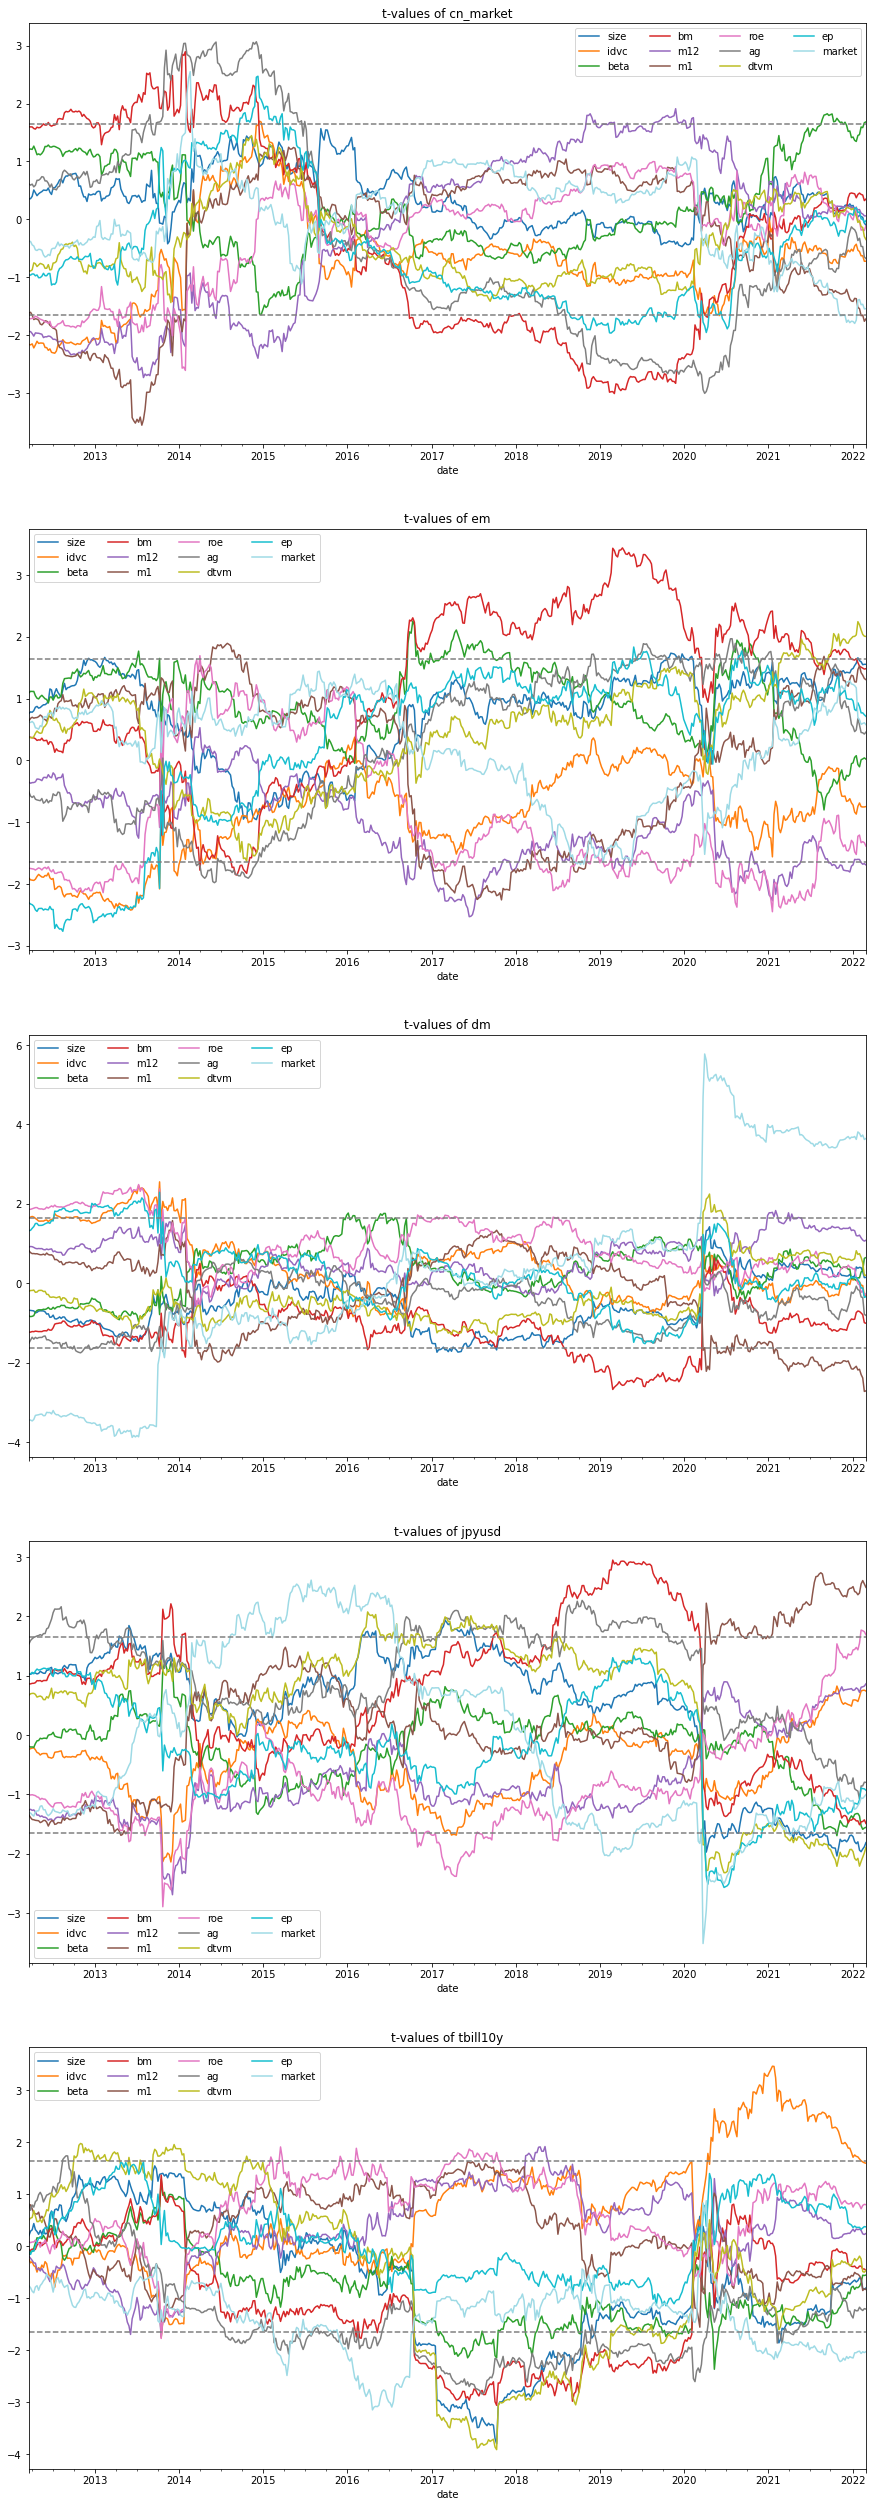

In [93]:
fore = pd.DataFrame.from_dict(fore, orient='index', columns = endog.columns)
fore.index = endog.index[261:]
fore2 = pd.DataFrame.from_dict(fore2, orient='index', columns = endog.columns)
fore2.index = endog.index[261:]

fig, axes = plt.subplots(figsize=(15,45), nrows = len(t_values.keys()))
i = 0
for key in t_values.keys():
    df = pd.DataFrame.from_dict(t_values[key], orient='index', columns = endog.columns)
    df.index = endog.index[261:]
    df.iloc[-520:, ].plot(title = "t-values of {}".format(key), ax = axes[i], colormap = "tab20")
    pd.Series({col: 1.645 for col in df.index}).iloc[-520:, ].plot(style='--',color='tab:gray', ax = axes[i])
    pd.Series({col: -1.645 for col in df.index}).iloc[-520:, ].plot(style='--',color='tab:gray', ax = axes[i])
    axes[i].legend(df.columns, ncol = 4)
    i += 1

In [107]:
res.tvalues.T.style.apply(lambda x: ["background: yellow" if abs(v)>1.645 else "" for v in x], axis = 1).format("{:.2f}")

,const,cn_market,hk_market,em,dm,usd,tbill,L1.size,L1.idvc,L1.beta,L1.bm,L1.m12,L1.m1,L1.roe,L1.ag,L1.dtvm,L1.ep,L1.market
size,0.97,-0.50,0.49,1.88,0.04,-1.67,-1.31,-0.26,0.51,0.97,0.08,-1.00,2.33,-0.04,-0.57,0.16,-0.27,-1.21
idvc,-2.29,-0.23,-0.88,-1.04,-0.60,1.35,2.31,-1.22,-1.33,0.49,0.41,1.92,0.44,-0.03,1.69,0.81,-0.09,2.04
beta,1.20,1.34,0.32,0.23,0.72,-1.79,-1.14,1.88,2.10,-1.14,-0.94,-1.06,-0.42,0.09,-1.59,-0.61,0.55,-2.31
bm,0.13,0.29,-0.68,1.71,-1.21,-1.30,-0.59,-0.98,0.13,0.77,0.63,-0.37,1.14,0.99,-0.39,0.91,-0.60,-0.58
m12,-0.19,0.08,0.11,-1.69,1.17,0.83,0.34,0.69,0.18,-0.98,-1.22,-0.55,-1.16,-0.94,-0.38,-0.06,0.68,1.19
m1,0.28,-1.20,-0.87,0.95,-2.48,1.79,-0.34,-2.07,-3.25,-1.15,2.06,0.48,-1.83,1.32,-0.07,0.83,-1.29,1.97
roe,-0.12,0.09,-0.07,-1.72,0.14,0.56,0.98,0.27,-0.31,-0.19,-0.27,1.80,-0.32,-0.66,1.24,-0.33,1.41,1.23
ag,0.53,-0.41,-0.87,0.45,-1.30,0.08,-0.75,-1.78,0.17,0.78,1.23,-0.48,0.50,1.01,-0.53,1.78,-1.61,0.68
dtvm,0.32,-0.54,0.04,2.17,-0.01,-1.62,-0.75,-0.27,1.10,1.07,-0.15,-0.58,2.87,-1.14,-0.84,-0.14,0.39,-0.89
ep,-0.38,0.11,-1.06,0.76,-0.45,-0.95,0.29,-0.82,0.32,0.99,-0.68,0.71,1.50,-0.72,0.84,0.78,0.91,-0.23


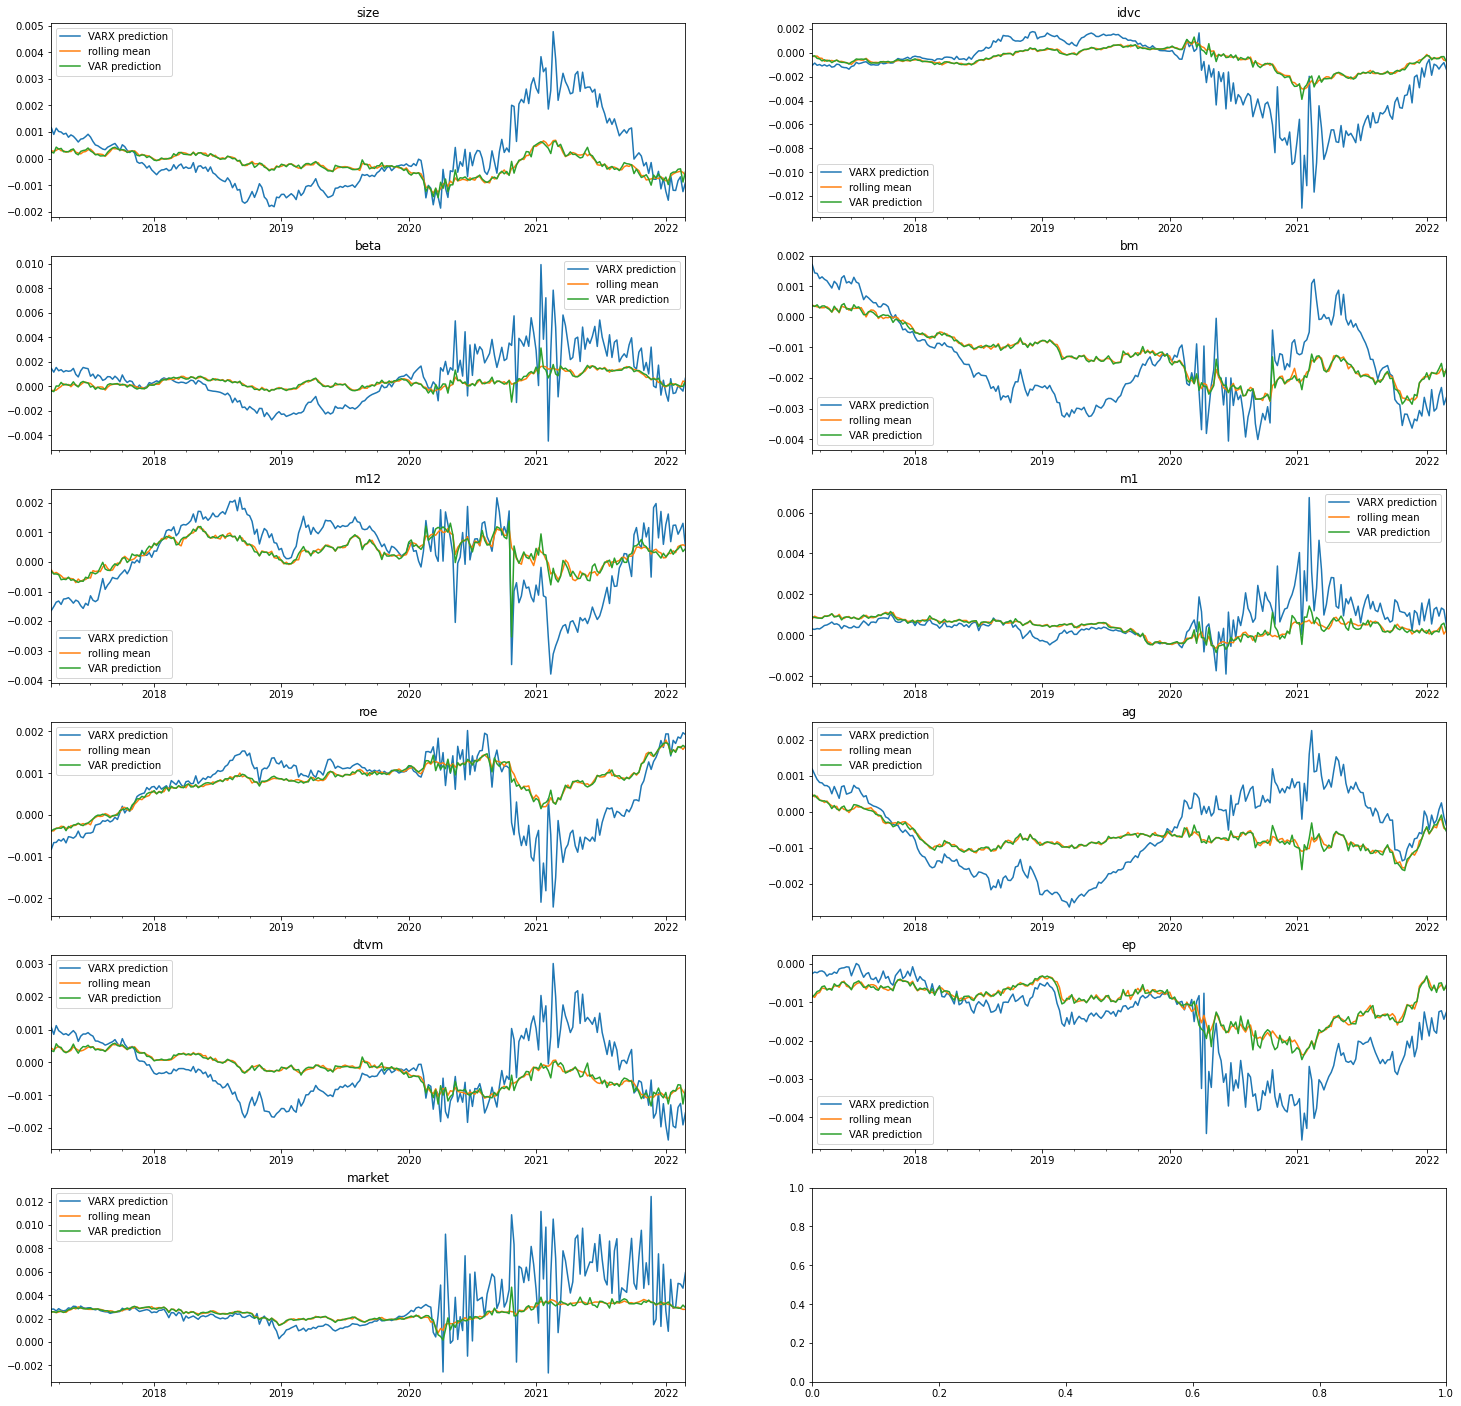

In [35]:
fig, axes = plt.subplots(figsize=(25,25), nrows = 6, ncols = 2)
# model forecasts comparison
for i, col in enumerate(endog.columns):
    rolling = endog[col].iloc[1:].rolling(window=260, min_periods=260).mean().shift(1)
    df = pd.merge(fore[col], rolling, left_index=True, right_index=True)
    df.join(fore2[col]).iloc[-260:, ].plot(ax=axes[i//2, i%2], title=col)
    axes[i//2, i%2].set_xlabel("")
    axes[i//2, i%2].legend(['VARX prediction', 'rolling mean', 'VAR prediction'])

In [172]:
i = 248
# get window data
exogf = exog.iloc[(i-1):i+249,:]
endogf = endog.iloc[i:i+250, :]
endogf.index = range(250)
exogf.index = range(250)

# fit model
mod = sm.tsa.VAR(endogf, exog=exogf)
res = mod.fit(1)

In [ ]:
# store t_values
for variable in t_values.keys():
    t_values[variable][i+260] = res.tvalues.loc[variable,:].values
#     name1 = '%s_market' %exog_group[code][0][:2]
#     t_cn[i+260] = res.tvalues.loc[name1,:].values
#     if len(exog_group[code]) == 2:
#         name2 = '%s_market' %exog_group[code][1][:2]
#         t_us[i+260] = res.tvalues.loc[name2,:].values


#     np.mean(exog.iloc[(i-1):i+259,:]) # mean
#exog.values[i+259,:] # lastest
exog_future = np.reshape(np.tile(np.mean(exog.iloc[i+207:i+259,:]),4),(4,len(exog_group[code])+len(exog_group2))) # assume a stable market in the next 4 weeks
fore[i+260] = res.forecast(endogf.values[-1:], exog_future=exog_future, steps = 4)[3]

n = len(endog.columns)
k = len(exog.columns)
A = res.params.iloc[1+k:, :].T
B = res.params.iloc[1:1+k, :].T
term1 = linalg.inv(np.diag(np.ones(n * n)) - np.kron(A, A))
term2 = np.dot(np.kron(B, B), np.reshape(exog.cov().values, k*k)) + np.reshape(res.sigma_u.values, newshape=121, order='F')
f_sigma_vec = np.dot(term1, term2)
f_sigma = np.reshape(f_sigma_vec, (n, n))

if (abs(linalg.eigvals(A))>1).any():
    print("not stable at time {}".format(i))

if (linalg.eigvals(f_sigma)<0).any():
    print("not positive semi-definite at time {}".format(i))

if not res.is_stable():
    print("not stable based on params")

mod2 = sm.tsa.VAR(endogf)
res2 = mod2.fit(1)
fore2[i+260] = res2.forecast(endogf.values[-1:], steps = 4)[3]

if i == n -260-1:
    print(res.summary())
    print("")

In [ ]:
mod = sm.tsa.VARMAX(endog, order=(1,0), exog=exog)
res = mod.fit(maxiter=100)
print(res.summary())

print(time.process_time()-start)

In [ ]:
# online example 1 for reference
dta = sm.datasets.webuse('lutkepohl2', 'https://www.stata-press.com/data/r12/')
dta.index = dta.qtr
dta.index.freq = dta.index.inferred_freq
endog = dta.loc['1960-04-01':'1978-10-01', ['dln_inv', 'dln_inc', 'dln_consump']]
exog = pd.concat([endog['dln_consump'],pd.Series([1]*75, index=endog.index)], axis=1)
mod = sm.tsa.VARMAX(endog[['dln_inv', 'dln_inc']], order=(2,0), exog=exog)
res = mod.fit(maxiter=100)
print(res.summary())

In [ ]:
# online example 2 for reference
dta = sm.datasets.webuse('lutkepohl2', 'https://www.stata-press.com/data/r12/')
dta.index = dta.qtr
dta.index.freq = dta.index.inferred_freq
endog = dta.loc['1960-04-01':'1978-10-01', ['dln_inv', 'dln_inc', 'dln_consump']]
endog.columns = ['y1', 'y2', 'x']
exog = endog['x']
mod = sm.tsa.VAR(endog[['y1', 'y2']], exog=exog)
res = mod.fit(2)
print(res.summary())